# Adaptive PDE discretizations on cartesian grids
## Volume : Non-divergence form PDEs## Part : Monotone numerical schemes
## Chapter : Linear partial differential equations

This notebook illustrates the use of monotone finite difference schemes to compute viscosity solutions of PDEs, in two space dimensions. We address both first order and second order problems, but focus on linear equations.

In the second order case, our numerical schemes are adaptive and depend on Selling's decomposition of the diffusion tensors.

[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. A first order linear equation](#1.-A-first-order-linear-equation)
    * [1.1 Vector fields in the upper quadrant](#1.1-Vector-fields-in-the-upper-quadrant)
    * [1.2 General vector field](#1.2-General-vector-field)
    * [1.3 Mock boundary conditions](#1.3-Mock-boundary-conditions)
  * [2. A second order linear equation](#2.-A-second-order-linear-equation)
    * [2.1 Varadhan's formula](#2.1-Varadhan's-formula)
  * [3. Second-order scheme with upwind first order differences](#3.-Second-order-scheme-with-upwind-first-order-differences)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('LinearMonotoneSchemes2D','NonDiv'))

In [2]:
from agd import Selling
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
from agd import Domain

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg 

Some utility functions

In [4]:
norm = ad.Optimization.norm
    
def streamplot_ij(X,Y,VX,VY,subsampling=1,*varargs,**kwargs):
    def f(array): return array[::subsampling,::subsampling].T
    return plt.streamplot(f(X),f(Y),f(VX),f(VY),*varargs,**kwargs) # Transpose everything

## 1. A first order linear equation

We numerically compute the *viscosity* solution of the equation
$$
    1-<\nabla u(x), \omega(x)>=0
$$
over some domain, with dirichlet boundary conditions.
In general, there exists no classical solution. The viscosity solution therefore has a jump over part of the domain boundary.
In addition, a technical condition is required for the existence of a viscosity solution: the equation
$$
    \gamma'(t) = \omega(\gamma(t)),
$$
solved *backwards in time* from a point $x$, must lead to some point $x_*$ of the domain boundary in finite time $T(x)$. Then 
$$
u(x) = T(x) + b(x_*),
$$
where $b$ denotes the boundary condition.

First let us define the discretization grid.

In [5]:
#Define the square [-1,1]^2, sampled on a cartesian grid
aX0 = np.linspace(-1,1); aX1 = aX0
X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))
shape = X.shape[1:]

Set the boundary conditions, by choosing a domain, an adequate value, and the grid.

In [6]:
bc_domain = Domain.Ball([0,0],0.9)
def bc_value(x): return 0.3*np.sin(2*np.pi*(x[0]+x[1]))

bc = Domain.Dirichlet(bc_domain,bc_value,X)

### 1.1 Vector fields in the upper quadrant

We assume here that $\omega_0(x)\geq 0$ and $\omega_1(x)\geq 0$, where $\omega(x) = (\omega_0(x),\omega_1(x))$.

A monotone numerical scheme for the considered PDE, at a point $x=(x0,x1)$ in the interior of the domain, is 
$$
    1 - \omega_0(x) \frac{u(x_0+h,x_1)-u(x)} h - \omega_1(x) \frac{u(x_0,x_1+h)-u(x)} h= 0.
$$

If $(x_0+h,x_1)$ falls out of the domain, then the adequate value on $\partial \Omega$ is extracted from the boundary conditions, as explained in notebook [subsets of R^d](../Notebooks_Algo/SubsetRd.ipynb).

In [7]:
def Scheme(u,omega,bc):
    omega0,omega1 = omega
    residue = 1. - omega0*bc.DiffUpwind(u,(1,0)) - omega1*bc.DiffUpwind(u,(0,1)) # 1-<grad u,omega> = 0
    return np.where(bc.interior,residue,u-bc.grid_values) # Placeholders outside the interior

In [8]:
omega = np.stack( (1.3+np.sin(np.pi*X[1]), np.cos(np.pi*(X[0]+X[1])/4)) )

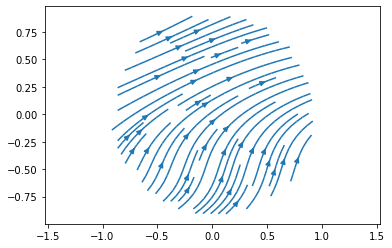

In [9]:
plt.axis('equal')
streamplot_ij(*X,*omega*bc.interior);

We can evaluate the scheme on an arbitrary guess numpy array, which produces a non-zero residue.

(-1.0, 1.0, -1.0, 1.0)

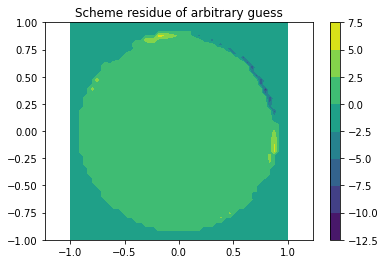

In [10]:
u = np.zeros(bc.shape) # Arbitrary guess (here zero)
residue = Scheme(u,omega,bc)

plt.title("Scheme residue of arbitrary guess")
plt.contourf(*X,residue); plt.colorbar(); plt.axis('equal')

In order solve the scheme, we evaluate it on a function featuring automatic differentiation information, here of sparse type, and solve the residue for zero.

In [11]:
u_ad = ad.Sparse.identity(constant=u) # Initial guess (here zero), with autodiff information
residue_ad = Scheme(u_ad,omega,bc)
solution = u + residue_ad.solve()

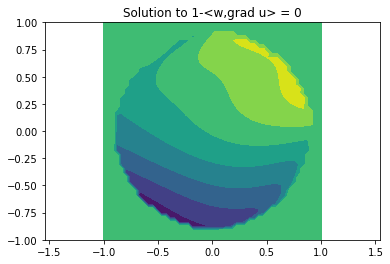

In [12]:
plt.axis('equal'); plt.title('Solution to 1-<w,grad u> = 0')
plt.contourf(*X,solution);

### 1.2 General vector field

If the vector field $\omega$ does not remain in a fixed quadrant, then the numerical scheme needs to be adaptive, and use upwind finite differences:
$$
    1 - |\omega_0(x)| \frac{u(x_0+s_0(x)h,x_1)-u(x)} h - |\omega_1(x)| \frac{u(x_0+s_1(x)h,x_1)-u(x)} h= 0,
$$
where $s_0(x)$ denotes the sign of $\omega_0(x)$, and likewise for $s_1(x)$.

In [13]:
def Scheme(u,omega,bc):
    
    # Compute the scheme coefficients and offsets
    coefs = np.abs(omega)
    coefs = bc.as_field(coefs)
    
    basis = bc.as_field(np.eye(len(omega)))
    offsets = np.sign(omega)*basis
    
    # Compute the first order finite differences
    du = bc.DiffUpwind(u,offsets.astype(int))
    
    # 1-<grad u,omega> = 0 in interior
    residue = 1.-lp.dot_VV(coefs,du)
    
    # Placeholders on boundary
    return np.where(bc.interior,residue,u-bc.grid_values) 

In [14]:
omega2 = np.stack( (1.3+np.sin(np.pi*X[1]), np.cos(np.pi*(2*X[0]+X[1])/2)) )

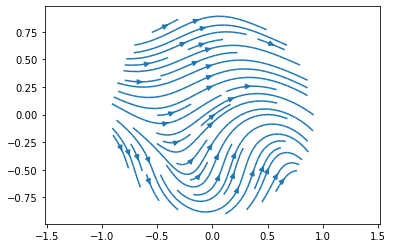

In [15]:
plt.axis('equal')
streamplot_ij(*X,*omega2*bc.interior);

In [16]:
u_ad = ad.Sparse.identity(bc.shape)
residue_ad = Scheme(u_ad,omega2,bc)
solution = residue_ad.solve()

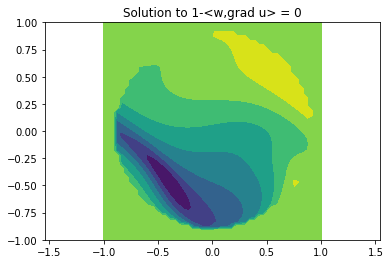

In [17]:
plt.axis('equal'); plt.title('Solution to 1-<w,grad u> = 0')
plt.contourf(*X,solution);

### 1.3 Mock boundary conditions

A different way of implementing Dirichlet boundary conditions, simpler and cruder, is to extend them to the full domain complement. We refer to this approach as mock boundary conditions.

In [18]:
u_ad = ad.Sparse.identity(bc.shape)
residue_ad = Scheme(u_ad,omega2,bc.Mock) # Mock boundary conditions, extended to the whole domain complement
solution = residue_ad.solve()

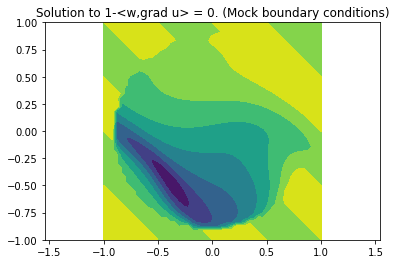

In [19]:
plt.axis('equal'); plt.title('Solution to 1-<w,grad u> = 0. (Mock boundary conditions)')
plt.contourf(*X,solution);

We can also directly construct the mock boundary conditions, by providing an array of values to be used as boundary conditions, and the grid scale.

In [20]:
bc_mock_grid_values = bc.value(X) # Evaluate the boundary conditions on the full grid
bc_mock_grid_values[bc.interior]=np.nan # Specify domain interior by NaNs

bc_mock = Domain.MockDirichlet(bc_mock_grid_values, bc.gridscale)

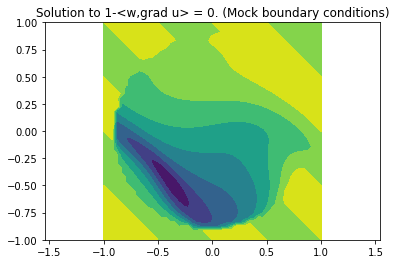

In [21]:
u_ad = ad.Sparse.identity(bc_mock.shape)
residue_ad = Scheme(u_ad,omega2,bc_mock) # Mock boundary conditions, extended to the whole domain complement
solution = residue_ad.solve()

plt.axis('equal'); plt.title('Solution to 1-<w,grad u> = 0. (Mock boundary conditions)')
plt.contourf(*X,solution);

## 2. A second order linear equation

We consider the linear second order equation
$$
    c(x) + m(x) u(x) + <\omega(x),\nabla u(x)> - \mathrm{Tr}(D(x)\nabla^2 u(x)) = 0,
$$
with Dirichlet boundary conditions. For monotony, one needs to assume that $a$ is non-negative, and $D$ is positive semi-definite.

In contrast with the first order examples:
* There exists a classical solution. Hence there is no discontinuity in the viscosity solution.
* We can use a centered finite difference scheme for the first order term, since the it is dominated by the monotony of the second order term.

We use adaptive finite differences, determined by a decomposition of the tensor field
$$
    D(x) = \sum_{1 \leq i \leq n} \mu_i(x) e_i(x) e_i(x)^T,
$$
where $\mu_i(x)$ is non-negative, and $e_i(x)$ has integer offsets.
This induces a decomposition of the vector field
$$
    \omega(x) = \sum_{1 \leq i \leq n} \nu_i(x) e_i(x)
$$
where $\nu_i(x) = \mu_i(x)<D(x)^{-1}\omega(x),e_i(x)>$.
The numerical scheme eventually reads:
$$
    a(x) u(x) 
    {+} \sum_{1 \leq i \leq n} \nu_i(x) \frac{u(x+h e_i(x))-u(x-h e_i(x))} {2 h} 
    {-} \sum_{1 \leq i \leq n} \mu_i(x) \frac{u(x+h e_i(x))-2 u(x)+ u(x-h e_i(x))} {h^2}.
$$

In [22]:
def SchemeCentered(u,cst,mult,omega,diff,bc,ret_hmax=False):
    """Discretization of a linear non-divergence form second order PDE
        cst + mult u + <omega,grad u>- tr(diff hess(u)) = 0
        Second order accurate, centered yet monotone finite differences are used for <omega,grad u>
        - bc : boundary conditions. 
        - ret_hmax : return the largest grid scale for which monotony holds
    """
    # Decompose the tensor field
    coefs2,offsets = Selling.Decomposition(diff)
    
    # Decompose the vector field
    scals = lp.dot_VA(lp.solve_AV(diff,omega), offsets.astype(float))
    coefs1 = coefs2*scals
    if ret_hmax: return 2./norm(scals,ord=np.inf)
    
    # Compute the first and second order finite differences    
    du  = bc.DiffCentered(u,offsets)
    d2u = bc.Diff2(u,offsets)
    
    # In interior : cst + mult u + <omega,grad u>- tr(diff hess(u)) = 0
    coefs1,coefs2 = (bc.as_field(e) for e in (coefs1,coefs2))    
    residue = cst + mult*u +lp.dot_VV(coefs1,du) - lp.dot_VV(coefs2,d2u)
    
    # On boundary : u-bc = 0
    return np.where(bc.interior,residue,u-bc.grid_values)

Solve a $1-\Delta u = 0$ over a square domain, with null Dirichlet boundary conditions. 
(The mathematician's preferred numerical problem, according to B.M.)

In [23]:
# Define the problem parameters
cst=1.
mult=0.
omega = np.array((0,0))
diff = np.array( ((1,0),(0,1)) )

Since the PDE is solved on the whole grid, mock boundary conditions will be enough for our purposes.
Note that:
* First argument is the shape of the domain. Equivalently, provide an array full of NaNs with this shape.
* A padding is specified for values falling outside the grid.

In [24]:
bc_whole = Domain.MockDirichlet(bc.shape, bc.gridscale, padding=0.)

In [25]:
u_ad = ad.Sparse.identity(bc.shape)
residue_ad = SchemeCentered(u_ad,cst,mult,omega,diff,bc_whole)
solution = residue_ad.solve()

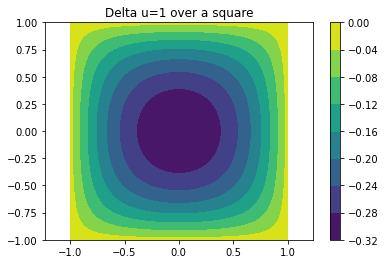

In [26]:
plt.axis('equal'); plt.title("Delta u=1 over a square")
plt.contourf(*X,solution); plt.colorbar();

### 2.1 Varadhan's formula

We turn to Varadhan's formula for more interesting examples.
First we solve 
$$
    u - \epsilon^2 \mathrm{Tr}(D \nabla^2 u) = 0
$$
with $u(x_0)=1$ at some given point $x_0$, and null boundary conditions on the square boundary. 
Then we apply the following change of unknown, related with the *Hopf-Cole transformation*
$$
    v(x) := -\epsilon \ln u_\epsilon(x).
$$
The function $v$ approximates the Riemmanian distance from $x_0$, for the metric $M:=D^{-1}$ defined by the inverses of the diffusion tensors.

We reproduce some examples from [I Computing distance maps and geodesics using Varadhan's formulas](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/AdaptiveGridDiscretizations/master/Notebooks/VaradhanGeodesics.ipynb).
A number of small differences distinguish the implementation presented in that other notebook:
* The laplacian is in divergence form. (Presumably better)
* The boundary conditions are of Neumann type. (Presumably better)
* The numerical scheme is not defined in the notebook, but in an external routine. (Less pedagogical, but presumably faster) 

**Metric specified in terms of eigenvectors and eigenvalues.**
In this example, the metric tensors are specified as 
$$
    M(x) = \lambda_1(x)^{-2} v_1(x) v_1(x)^T + \lambda_2(x)^{-2} v_2(x) v_2(x)^T.
$$
The scalars $\lambda_1$ and $\lambda_2$ appearing in this expression should be regarded as the local velocity in the direction of $v_1$ and $v_2$ respectively.

In [27]:
# Create the domain
aX0 = np.linspace(-1,1,100); aX1=aX0;
X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))

gridscale = aX0[1]-aX0[0]
bc_grid_values = np.full(X.shape[1:],np.nan)
bc_grid_values[X.shape[1]//2,X.shape[2]//2] = 1

bc = Domain.MockDirichlet(bc_grid_values,gridscale,padding=0.) # Shape, gridscale, padding

In [28]:
# Generate the metric
eig1 = np.stack((np.ones(bc.shape),(np.pi/2)*np.cos(2*np.pi*X[0])))
eig1 /= scipy.linalg.norm(eig1,axis=0) 
eig2 = np.stack( (eig1[1],-eig1[0]) ) # Rotate eig1 by pi/2
lambda1, lambda2 = 0.8, 0.2
metric = lambda1**-2*lp.outer_self(eig1) + lambda2**-2*lp.outer_self(eig2)

In [29]:
# Relaxation parameter
epsilon=2*bc.gridscale

# Generate the PDE parameters
cst=0.
mult=1.
omega=bc.as_field(np.array([0.,0]))
diff = epsilon**2 * lp.inverse(metric)

In [30]:
u_ad = ad.Sparse.identity(bc.shape)
residue_ad = SchemeCentered(u_ad,cst,mult,omega,diff,bc)
solution = residue_ad.solve()

In [32]:
distance = -epsilon*np.log(solution)
plt.axis('equal'); plt.title("Riemannian distance, approximated using Varadhan's formula")
plt.contourf(*X,distance);

**Zermelo's navigation problem.**



In [33]:
# Generate the metric
metric = bc.as_field(np.eye(2))
drift = 0.8*np.sin(2*np.pi*X[0])*np.sin(2*np.pi*X[1]) * X / norm(X,ord=2,axis=0)
#metric = np.array( ((1,0),(0,1)) ); drift = 0.5*np.array( (1,1) )/np.sqrt(2) # Alternatively : constant drift

In [34]:
# Relaxation parameter
epsilon=3*bc.gridscale

# Generate the PDE parameters
cst=0.
mult=1.
omega=2*epsilon*drift
diff = epsilon**2 * (lp.inverse(metric) - lp.outer_self(drift))

In [35]:
u_ad = ad.Sparse.identity(bc.shape)
residue_ad = SchemeCentered(u_ad,cst,mult,omega,diff,bc)
solution = residue_ad.solve()

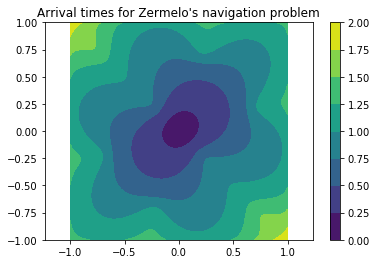

In [36]:
distance = -epsilon*np.log(solution)
plt.axis('equal'); plt.title("Arrival times for Zermelo's navigation problem")
plt.contourf(*X,distance); plt.colorbar();

In [37]:
grad = np.array(np.gradient(distance,bc.gridscale))
flow = lp.solve_AV(bc.as_field(metric),grad)
flow = flow/np.sqrt(lp.dot_VV(flow,grad)) + bc.as_field(drift)

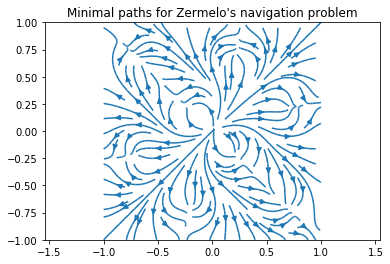

In [38]:
plt.axis('equal'); plt.title("Minimal paths for Zermelo's navigation problem")
streamplot_ij(*X,*flow);

## 3. Second-order scheme with upwind first order differences

For completeness, we present a non-centered scheme for second order linear equations.
In comparison with the centered scheme presented in the previous section, this one is:
* More diffusive, and only first order accurate.
* Unconditionally stable, independently of the grid scale.

In practice, we recommend using the centered scheme, unless the second order coefficients are degenerate or excessively small.

In [39]:
def SchemeUpwind(u,cst,mult,omega,diff,bc):
    """Discretization of a linear non-divergence form second order PDE
        cst + mult u + <omega,grad u>- tr(diff hess(u)) = 0
        First order accurate, upwind finite differences are used for <omega,grad u>
        - bc : boundary conditions. 
    """
    # Decompose the tensor field
    coefs2,offsets2 = Selling.Decomposition(diff)
    omega,coefs2 = (bc.as_field(e) for e in (omega,coefs2))    

    # Decompose the vector field
    coefs1 = -np.abs(omega)
    basis = bc.as_field(np.eye(len(omega)))
    offsets1 = -np.sign(omega)*basis
    
    # Compute the first and second order finite differences    
    du  = bc.DiffUpwind(u,offsets1.astype(int))
    d2u = bc.Diff2(u,offsets2)
    
    # In interior : cst + mult u + <omega,grad u>- tr(diff hess(u)) = 0
    residue = cst + mult*u +lp.dot_VV(coefs1,du) - lp.dot_VV(coefs2,d2u)
    
    # On boundary : u-bc = 0
    return np.where(bc.interior,residue,u-bc.grid_values)

In [40]:
u_ad = ad.Sparse.identity(bc.shape)
solutionUpwind = SchemeUpwind(u_ad,cst,mult,omega,diff,bc).solve()
solutionCentered = SchemeCentered(u_ad,cst,mult,omega,diff,bc).solve()

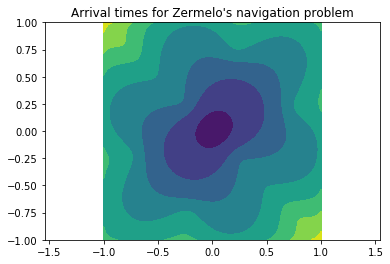

In [41]:
distanceUpwind = -epsilon*np.log(solutionUpwind)
plt.axis('equal'); plt.title("Arrival times for Zermelo's navigation problem")
plt.contourf(*X,distanceUpwind);

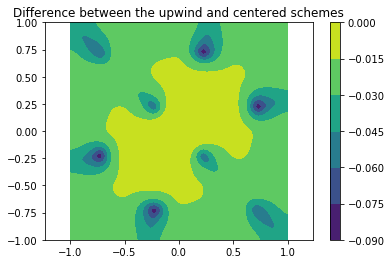

In [42]:
distanceCentered = -epsilon*np.log(solutionCentered)
plt.title('Difference between the upwind and centered schemes')
plt.contourf(*X,distanceUpwind-distanceCentered); 
plt.colorbar(); plt.axis('equal');